In [1]:
# Librerias a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as rnd


%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler # Usado para la estandarización de datos usando Z-score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [3]:
from sklearn_extra.cluster import KMedoids

## Load Data

In [141]:
beans = pd.read_excel('./Dry_Bean_Dataset.xlsx')
#beans = pd.read_excel('./Datasets/google_review_ratings.xlsx')
beans.shape

(13611, 16)

In [5]:
beans.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


## Elbow Method

Para poder determinar la cantidad de clusters de nuestros datos, se usará el método del codo, el que permite estimar la cantidad de clusters donde la separación de nuestros datos se vuelve óptima

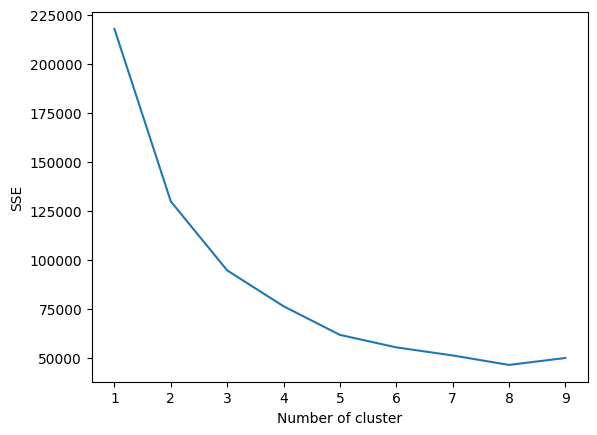

In [6]:
sse = {}
for e in range(1,10):
    scikit_kmeans = KMeans(n_clusters=e)
    pipeline = make_pipeline(StandardScaler(), scikit_kmeans).fit(beans)
    sse[e] = pipeline[-1].inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [103]:
number_clusters = 5

## Implementacion propia

In [8]:
# Implemantación del algoritmo de Clustering K-means mediante una clase
class Own_KMeans:

    # Constructor
    def __init__(self, data, n_clusters=8, max_iters=1000,  tol=0.00001):
        self._n_clusters = n_clusters
        self._clusters = [[] for i in range(n_clusters) ] # Creando n clusters segun se hallan indicado en la inicializacion 
        self._max_iters = max_iters
        self._data = data
        self._tol = tol
        self._scaler = StandardScaler()
        self.std_data()
        self._centroids = []
        self._sses = []
        self.labels_ = np.zeros(len(self._data)) # saves to which centroid has every point being assigned

    # Funcion que estandariza la data usando Z-score 
    def std_data(self):
        self._std_data = self._scaler.fit_transform(self._data)
    # Funcion que permite inicializar de forma aleatoria los centroides de k-means
    def initialize_centroids(self):
        for i in range(self._n_clusters):
            self._centroids.append(self._std_data[rnd.randrange(len(self._std_data))])
            
            
    def calculate_distance(self,val1, val2):
        return np.linalg.norm(val1-val2, axis=0)

    def assign_cluster(self):
        self._clusters = [[] for i in range(self._n_clusters) ]
        for i in range(len(self._std_data)):
            distances = []
            for j in range(len(self._centroids)):
                distances.append(self.calculate_distance(self._centroids[j],self._std_data[i]))

            to_assign =  np.argmin(distances)
            self.labels_[i] = to_assign
            self._clusters[to_assign].append(self._std_data[i])
        

    def calculate_new_centroids(self):
        new_centroids = []
        for c in range(self._n_clusters):
            new_centroids.append(np.mean(self._clusters[c], axis=0))
        return new_centroids

    # metodo que calcula la suma del error cuadrado entre iteraciones para emplear la tolerancia como medio de paro
    def sse(self):
        errors = []
        for c in range(len(self._centroids)):
            centroid = self._centroids[c]
            for i in range(len(self._clusters[c])):
                cluster = self._clusters[c]
                error = np.linalg.norm( cluster[i] - centroid, axis=0)
                errors.append(error**2)
        
        sse = np.sum(errors)
        self._sses.append(sse)

    def calculate_tolerance(self,actual_sse, prev_sse):
        return np.absolute(actual_sse - prev_sse)/prev_sse
        
            
    # Funcion principal que ejecuta el proceso completa usando los metodos auxiliares
    def kmeans(self):
        self.initialize_centroids()
       
        it = 0
        #while (len(self._sses) <= 1 or (it < self._max_iters and self.calculate_tolerance(self._sses[it], self._sses[it-1]) >= self._tol)) :
        while it <= self._max_iters:
            
            self.assign_cluster()

            # new centroids
           
            self._centroids = self.calculate_new_centroids()
            
            self.sse()
            if (it >= 1 and self.calculate_tolerance(self._sses[it], self._sses[it-1]) >= self._tol):
                break
            it += 1

        #for i in range(len(self.labels)):
                #self._clusters[self.labels[i]].append(self._std_data[i])
                
    def predict(self,new_data):
        try:
            std_new = self._scaler.fit_transform(new_data)
            predictions = np.zeros(len(std_new))
            for i in range(len(std_new)):
                distances = []
                for j in range(len(self._centroids)):
                    distances.append(self.calculate_distance(self._centroids[j],std_new[i]))
    
                to_assign =  np.argmin(distances)
                predictions[i] = to_assign
            
            return predictions
        except Exception as err:
            print(i)
            print(f"Unexpected {err=}, {type(err)=}")
        
            

    def clusters_viz(self):
        x = self._data[self._data.columns[0]]
        y = self._data[self._data.columns[1]]
        plt.scatter(x,y)
        plt.show()

In [104]:
own =  Own_KMeans(data=beans,n_clusters=5, max_iters = 1000000, tol = 0.000000001) 
own.kmeans()
metrics.silhouette_score(beans,own.labels_)

0.043812116332284205

In [115]:
reduced_data = PCA(n_components=2).fit_transform(beans)
own_kmeans = Own_KMeans(data=reduced_data,n_clusters=5, max_iters = 1000000, tol = 0.000000001) 
own_kmeans.kmeans()

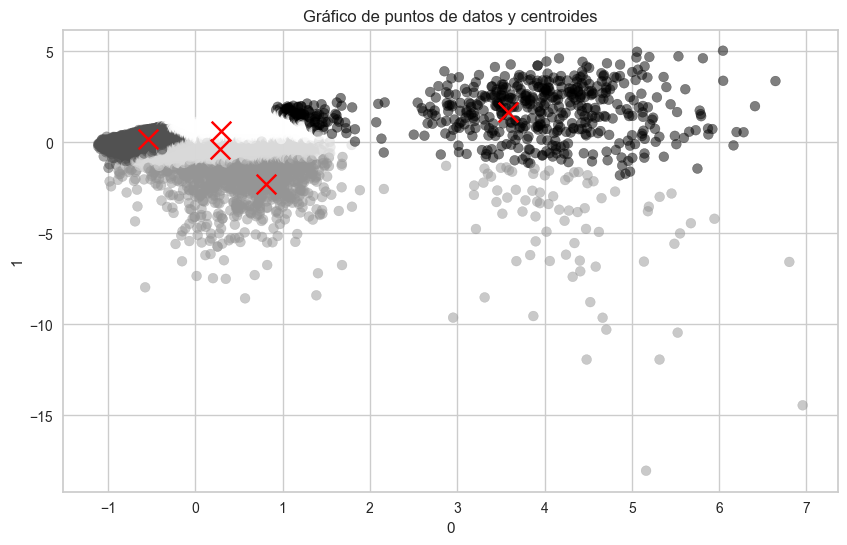

In [119]:

def plot_data_centroids(data, centroids,labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data.columns[0]], data[data.columns[1]], s=50, c=labels, alpha=0.5)
    plt.scatter(centroids[centroids.columns[0]], centroids[centroids.columns[1]], c='red', s=200, marker='x')
    plt.title('Gráfico de puntos de datos y centroides')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()
a = pd.DataFrame(own_kmeans._std_data)
plot_data_centroids(a , pd.DataFrame(own_kmeans._centroids, columns=a.columns),pd.DataFrame(own_kmeans.labels_))

## K-means using Scikit Learn

In [101]:
scikit_kmeans = KMeans(n_clusters=5)
pipeline_means = make_pipeline(StandardScaler(), scikit_kmeans).fit(beans)

In [63]:
pipeline_means[-1].inertia_

55050.26213984152

In [64]:
metrics.silhouette_score(beans,pipeline_means[-1].labels_)

0.034433631651325805

### Visualización en 2D usando reducción por PCA

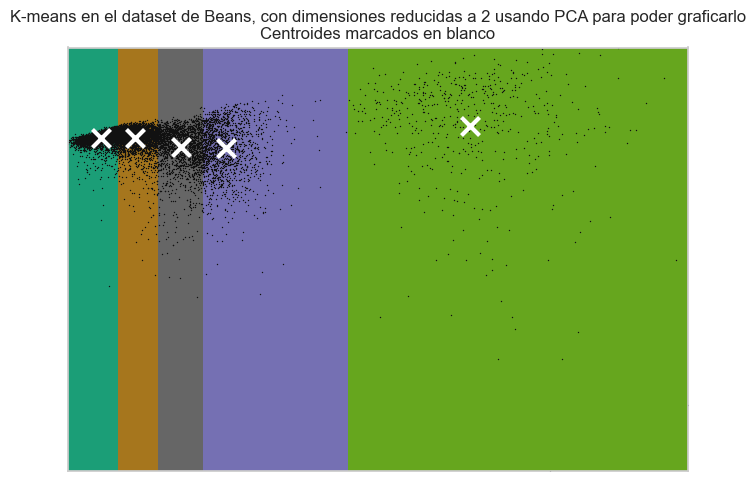

In [102]:
reduced_data = PCA(n_components=2).fit_transform(beans)
scikit_kmeans = KMeans(n_clusters=5).fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 10  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = scikit_kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Dark2,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = scikit_kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means en el dataset de Beans, con dimensiones reducidas a 2 usando PCA para poder graficarlo\n"
    "Centroides marcados en blanco"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## K-medoids using Scikit Learn

In [120]:
standarized = StandardScaler().fit_transform(beans)
pipeline_k_medoids = KMedoids(n_clusters=5).fit(standarized)

In [121]:
pipeline_k_medoids.inertia_

27420.97152579848

In [122]:
metrics.silhouette_score(beans,pipeline_k_medoids.labels_)

0.07914581767298333

### Visualización en 2D usando reducción por PCA

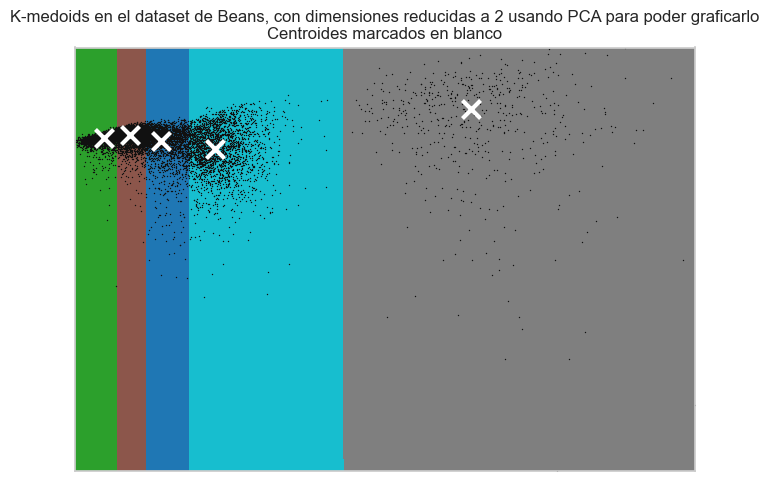

In [123]:
reduced_data = PCA(n_components=2).fit_transform(beans)
k_medoids = KMedoids(n_clusters=5).fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 10  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = k_medoids.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.tab10,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = k_medoids.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-medoids en el dataset de Beans, con dimensiones reducidas a 2 usando PCA para poder graficarlo\n"
    "Centroides marcados en blanco"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Hierchical Clustering using Scikit Learn

In [124]:
hierchical = AgglomerativeClustering(n_clusters=5)
pipeline_hier = make_pipeline(StandardScaler(), hierchical).fit(beans)

In [125]:
metrics.silhouette_score(beans,pipeline_hier [-1].labels_)

0.060743186257978005

## Comparacion mediante la silueta

In [137]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
def silhouette(data,method,n):
    
    range_n_clusters = [n for n in range(n)]
    
    #for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 1 columns
    fig, ax = plt.subplots(1, 1)
        
    
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
    ax.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
    clusterer = method
    cluster_labels = method.labels_
    silhouette_avg = metrics.silhouette_score(data, cluster_labels)
        # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
            # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
            
                # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
            
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
        
    
    plt.show()

### Silueta de K means de Scikit Learn

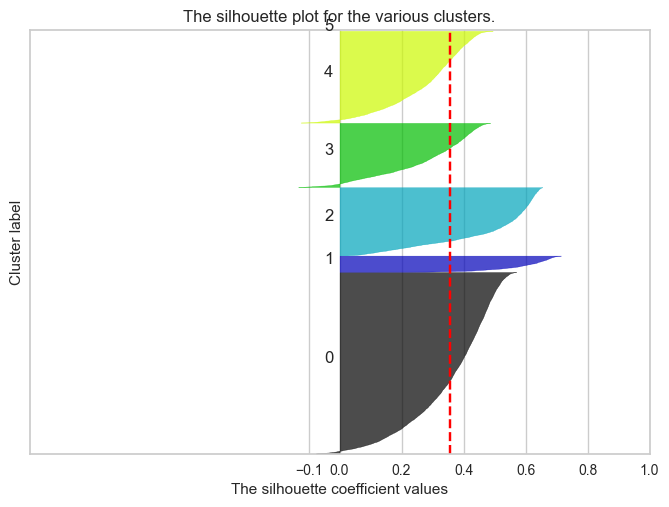

In [138]:
std = StandardScaler().fit_transform(beans)
silhouette(std,pipeline_means[-1],5) 

### Silueta de K medoids de Scikit Learn

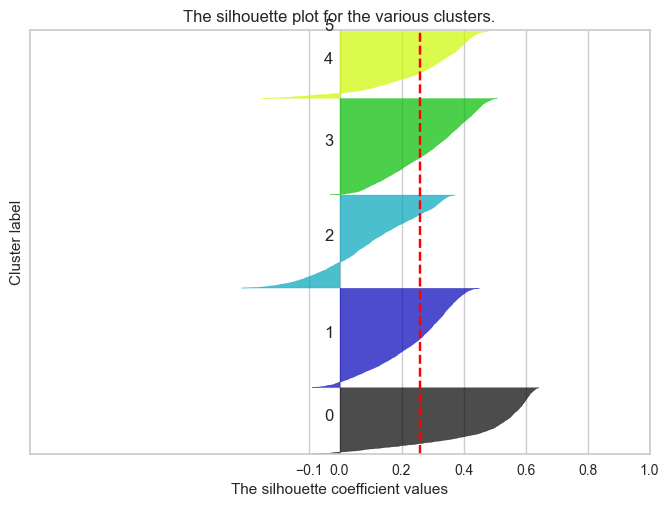

In [139]:
std = StandardScaler().fit_transform(beans)
silhouette(std,pipeline_k_medoids,5) 

### Silueta de Clustering Jerarquico de Scikit Learn

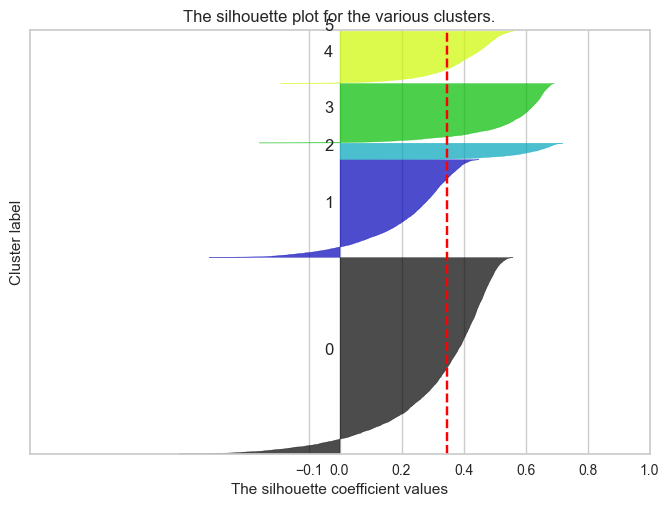

In [131]:
std = StandardScaler().fit_transform(beans)
silhouette(std,pipeline_hier[-1],5) 

### Silueta para implementación propia de K Means

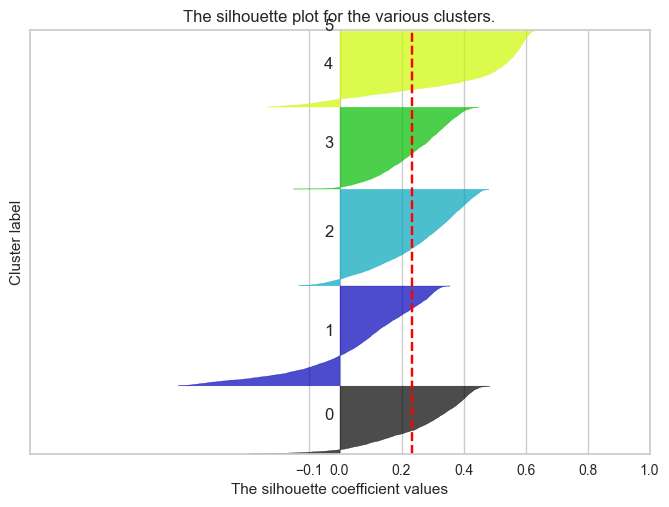

In [140]:
std = StandardScaler().fit_transform(beans)
silhouette(std,own,5) 

# Conclusiones

## K Means propio vs K Means Scikit

Al hacer la comparación de K means propio vs K means de la libería de Scikit, al momento de ejecutarlos, el implementado por la libreria fue mucho más eficiente y suele terminar varios segundos más rápido que la implementación propia, además de ser más robusto en cuanto a la selección de valores iniciales, pues cuenta con métodos como k-means++, que le permiten una inicialización probabilista mejor que la implementación únicamente por selección random de la propia, haciendolo menos suceptible en este aspecto a una inicialización desfavorable. 

Además, al trabajar con datos sin estandarizar, tiende a mostrarse aún más su robustez y eficiencia, pues logra terminar aún en materia de segundos, mientras que la implentación propia comienza a tardar minutos debido a las variaciones entre los datos, obligando a estandarizar y normalizar siempre, por motivos de rapidez de ejecución. 

Al comparar los valores de la silueta al usar 5 clusters, la implementación de la líbreria tienda a no variarmucho su valor en más o menos 0.01. Sin embargo, la implementación propia llega a tener variaciones entre 0.1 hasta 0.01 de diferencia en diferentes ejecuciones.  

En conclusión, la implementación de la libreía es como previamente mencionado, más robusta y confiable. 

## Comparacion entre los diferentes métodos de clustering basado en silueta

Al comparar los diferentes algoritmos, vemos lo siguiente: 

    * K means de la libreria fue mucho más consiste en separar sus clusters y mantener la cohesión interna lo más alta posible a pesar de encontrarse con una data que en muchos casos generaba solapimento entre ellos. 
    * K medoids y Clustering Jerarquico en cambio presentaron más casos de baja cohesion interna donde multiples valores podian parecerce  más a otros clusters que en el que se encontraban, al igual que la implementación propia de K means

Por ende, para este dataset, el empleo de K means de scikit learn fue el más efectivo a pesar de los solpamientos de los datos, para mantener la cohesión interna y la separación de clusters